# Analyzing Product Churn Trends: Understanding the Impact of Product Change ARR on Customer Product Retention

# Importing libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset

In [57]:
df_product = pd.read_csv("../staging/data_set/cleaned_product.csv")
df_exp = pd.read_csv("../staging/data_set/cleaned_expansion.csv")

# Convert dates

In [58]:
for df in [df_product, df_exp]:
    df["score_date"] = pd.to_datetime(df["score_date"], errors="coerce")
    df["year_month"] = df["score_date"].dt.to_period("M").astype(str)


## Compute Churn for Each Product Subscription

In [59]:
def compute_churn(df, col):
    prev = df.groupby("id")[col].shift(1)
    churn = ((prev == 1) & (df[col] == 0)).astype(int)
    return churn

# Calculate churn for each product tier and a combined churn signal
df_product["team_churn"] = compute_churn(df_product, "team_plus")
df_product["pro_churn"] = compute_churn(df_product, "pro_plus")
df_product["ent_churn"] = compute_churn(df_product, "ent_plus")

# Merge product and expansion data

In [60]:
df_merged = pd.merge(df_product, df_exp, on=["id", "year_month"], how="left")

# Compute churn rate per product tier

In [61]:
df_merged["team_plus_churn_rate"] = df_merged["team_churn"] / (df_merged["team_plus"] + 1e-6)
df_merged["pro_plus_churn_rate"] = df_merged["pro_churn"] / (df_merged["pro_plus"] + 1e-6)
df_merged["ent_plus_churn_rate"] = df_merged["ent_churn"] / (df_merged["ent_plus"] + 1e-6)


# Aggregate churn rate per product tier monthly

In [62]:
monthly_churn_rate = df_merged.groupby("year_month")[
    ["team_plus_churn_rate", "pro_plus_churn_rate", "ent_plus_churn_rate"]
].mean().reset_index()

# Visualization: Product Change ARR Trend

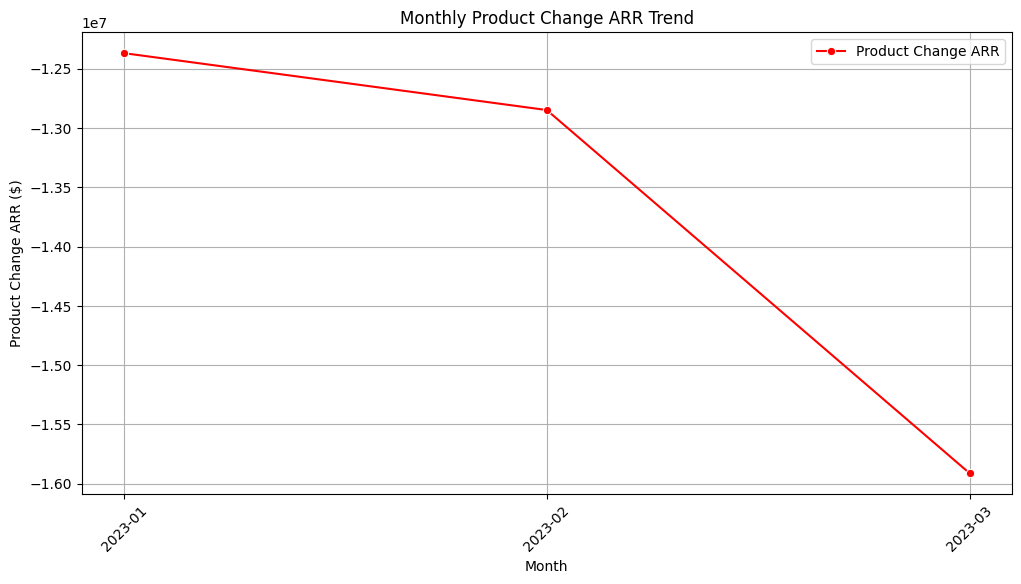

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_churn, 
    x="year_month", 
    y="product_change_arr", 
    marker="o", 
    color="red", 
    label="Product Change ARR"
)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Product Change ARR ($)")
plt.title("Monthly Product Change ARR Trend")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Churn Rate per Product Tier

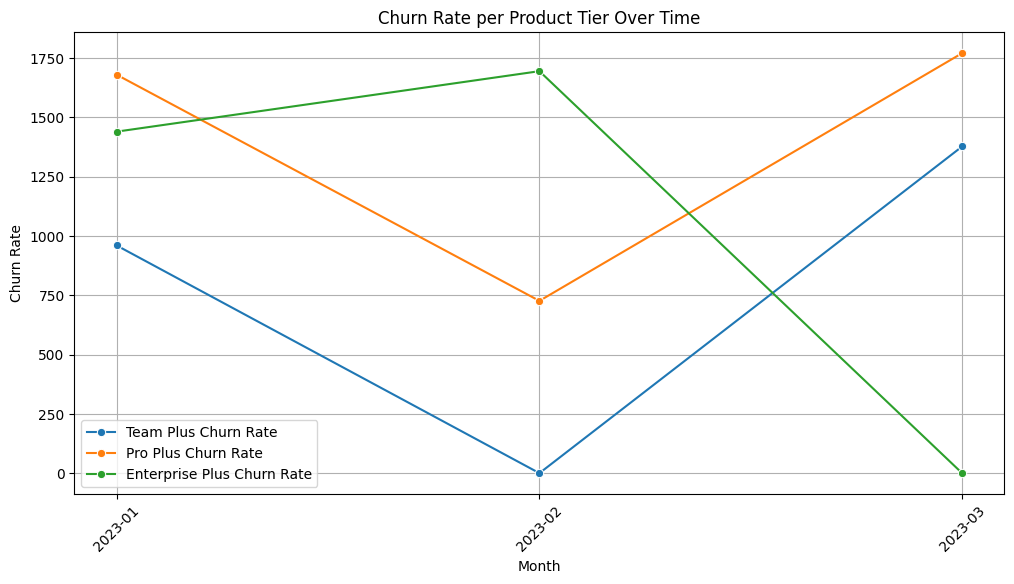

In [64]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_churn_rate, 
    x="year_month", 
    y="team_plus_churn_rate", 
    marker="o", 
    label="Team Plus Churn Rate"
)
sns.lineplot(
    data=monthly_churn_rate, 
    x="year_month", 
    y="pro_plus_churn_rate", 
    marker="o", 
    label="Pro Plus Churn Rate"
)
sns.lineplot(
    data=monthly_churn_rate, 
    x="year_month", 
    y="ent_plus_churn_rate", 
    marker="o", 
    label="Enterprise Plus Churn Rate"
)

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.title("Churn Rate per Product Tier Over Time")
plt.legend()
plt.grid(True)
plt.show()